In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt
from jax import grad, vmap
import jax.numpy as jnp
from scipy.integrate import solve_ivp
import argparse
import os
import functools
from flax.core import FrozenDict
# from experiments.Experiment import Experiment
import pickle
import torch
from utils.tools_2 import apply_selected_funcs
from layers.Enc_Dec import Encoder_Decoder
from utils.tools_2 import random_selection_arr_maker
from layers.output_grad_comp import output_selection
import subprocess
import h5py
import scipy.optimize as opt
from utils.tools_2 import apply_selected_funcs
import jax
from typing import Iterator, Tuple
from tqdm import tqdm
from jax import jit

GAMMA = 0.
library_functions = [ "(_)**2", "(_)**3"]
selection_length = 4
sub_selection_length = 2
d_model = 8
e_layers = 2
learning_rate = 1e-3
batch_size = 16
results_path = "./results/"
num_samples_total = 500
num_epochs = 100
svd_trunc_index = 20 # l_val
l_val = svd_trunc_index
r_val = 8

with open('era5_example1_reference_sample.pkl', 'rb') as file:
    reference_sample = pickle.load(file)

ref_sample_array = reference_sample['sample_arr']

gpu_devices = jax.devices("gpu")
if gpu_devices:
    device = gpu_devices[0]
else:
    device = jax.devices("cpu")[0]

# print("Using device:", device) # cuda:0

with open("era5_example_1_data.pkl", 'rb') as file:
    loaded_data = pickle.load(file)

data_var = loaded_data['u10m_values']
lat_vals = loaded_data['lat_vals']
long_vals = loaded_data['long_vals']

train_split = int(0.8*data_var.shape[0])
S_train_org = data_var[:train_split]
S_test_org = data_var[train_split:]

S_train = S_train_org.reshape(S_train_org.shape[0], S_train_org.shape[1] * S_train_org.shape[2]).T
S_test = S_test_org.reshape(S_test_org.shape[0], S_test_org.shape[1] * S_test_org.shape[2]).T

with open("../CAE_transf/tacc_vals.pkl", 'rb') as f:
    tacc_vals = pickle.load(f)

X_train = tacc_vals['X_train']
Y_train = tacc_vals['Y_train']
U_vals = tacc_vals['U_vals']
sing_vals = tacc_vals['sing_vals']
Vt_vals = tacc_vals['Vt_vals']

U_l = U_vals[:, :l_val]
Sig_l = sing_vals[:l_val]
Vt_l = Vt_vals[:l_val, :]

# print(type(U_l), type(X_train))

A_operator = Y_train @ Vt_l.T @ jnp.linalg.inv(jnp.diag(Sig_l)) @ U_l.T
A_tilde_operator = U_l.T @ A_operator @ U_l
X_tilde = U_l.T @ X_train

phi_mat = jnp.vstack([
    jnp.eye(r_val, dtype=jnp.float32),
    jnp.zeros((l_val - r_val, r_val), dtype=jnp.float32),
])

# \tilde{X}, \hat{X}:
U_r = U_l @ phi_mat
X_hat = U_r.T @ X_train
trunc_dim = X_hat.shape[0]

result_path = "./results/era5_example2_wotanh_tdim8_slen4_sslen2_ns500_bs16_ne100_dm8_el2_clipped_lr/"

In [14]:
with open(result_path + 'final_results.pkl', 'rb') as f:
    final_results = pickle.load(f)

batch_reward_list = final_results["batch_reward_list"]
best_sample_list = final_results["best_sample_list"]
lrs_sample_rewards = final_results["lrs_sample_rewards"]
track_samples = final_results['track_samples']
track_probs = final_results['track_probs']
preserved_params = final_results["saved_params"]
preserved_lrs = final_results['saved_lrs']
preserved_sum_batch_grads = final_results['preserved_sum_batch_grads']
adv_vals= final_results["adv_vals"]


In [15]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from flax.traverse_util import flatten_dict, unflatten_dict
import optax  # optional, for global_norm

# 1) Stack every leaf on a new axis=0  -> shapes become (T, ...)
stacked = jax.tree.map(lambda *xs: jnp.stack(xs, axis=0), *preserved_sum_batch_grads)
print(stacked['params']['final_layer']['kernel'].shape)


(3100, 5, 1)


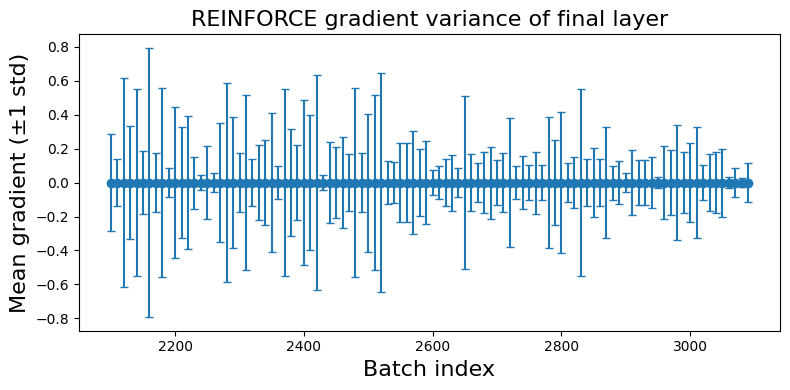

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def extract_param_list(grads, key_path):
    """
    Walk each batch dict along key_path and return a list of numpy arrays.
    key_path should be something like ['params','final_layer','kernel'].
    """
    
    out = []
    for batch in grads:
        d = batch
        for k in key_path:
            d = d[k]
        # d is now a JAX Array (or np.ndarray); convert to numpy
        arr = np.array(d)  
        out.append(arr)
    return out


kernels = stacked['params']['layer_0']['net1']['kernel'] # (, 5,8)
# kernels = stacked['params']['layer_0']['net2']['kernel'] # (, 8,5)
# kernels = stacked['params']['layer_1']['net1']['kernel'] # (, 5,8)
# kernels = stacked['params']['layer_1']['net2']['kernel'] # (, 8,5)
# kernels = stacked['params']['final_layer']['kernel'] # (, 5,1)

means = [arr.mean() for arr in kernels]
stds  = [arr.std()  for arr in kernels]

# import matplotlib.pyplot as plt
# plt.errorbar(np.arange(len(means)), means, yerr=stds, fmt='o', capsize=3)
# plt.xlabel('Batch index', fontsize = 16)
# plt.ylabel('Mean gradient (±1 std)', fontsize = 16)
# plt.title('REINFORCE gradient variance of final layer', fontsize = 16)
# plt.show()

# print(len(means)) # 3100

all_idxs = np.arange(len(means))
sampled_idxs = all_idxs[::10]           # 0, 10, 20, …

# slice your stats to only those points
sampled_means = np.array(means)[::10]
sampled_stds  = np.array(stds)[::10]


plt.figure(figsize=(8,4))

# plt.errorbar(
#     sampled_idxs[-100:],
#     sampled_means[-100:],
#     yerr=sampled_stds[-100:],
#     fmt='o',
#     capsize=3
# )


plt.errorbar(
    sampled_idxs[-100:],
    sampled_means[-100:],
    yerr=sampled_stds[-100:],
    fmt='o',
    capsize=3
)



# plt.xticks(sampled_idxs)                     
plt.xlabel('Batch index', fontsize=16)
plt.ylabel('Mean gradient (±1 std)', fontsize=16)
plt.title('REINFORCE gradient variance of final layer', fontsize=16)
plt.tight_layout()
plt.show()  


# no bias in the network:
# test = stacked['params']['layer_0']['net1']['kernel'] # (, 5,8)
# test = stacked['params']['layer_0']['net2']['kernel'] # (, 8,5)
# test = stacked['params']['layer_1']['net1']['kernel'] # (, 5,8)
# test = stacked['params']['layer_1']['net2']['kernel'] # (, 8,5)
# test = stacked['params']['final_layer']['kernel'] # (, 5,1)

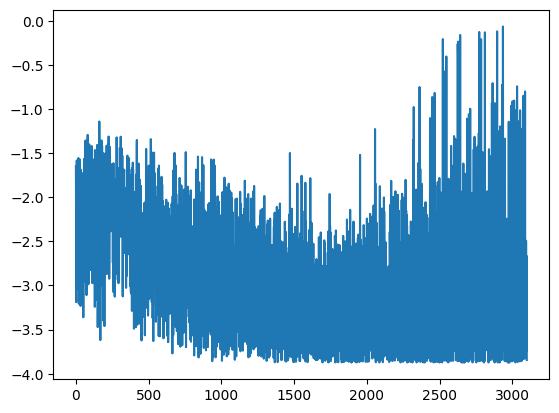

In [6]:
# print(preserved_sum_batch_grads[226])
# print(adv_vals[225])

# print(len(adv_vals), adv_vals[0].shape)
# adv_vals_array = np.array(adv_vals[:225])

min_adv_vals = []
for i in range(len(adv_vals)):
    min_adv_vals.append(np.min(adv_vals[i]).item())
    # print(adv_vals[i].shape)

# print(len(min_adv_vals))

plt.plot(min_adv_vals)


# plt.plot(min_adv_vals)
# print(min_adv_vals[220:230])


In [7]:
lr_mod_vals = lrs_sample_rewards['modified_learning_rates']
# print(lr_mod_vals[220: 230])
# plt.plot(lr_mod_vals[:226])

print(lr_mod_vals[226])
print(min_adv_vals[226])
        

0.009438087
-2.2444348335266113


In [8]:
print(preserved_sum_batch_grads[0])

{'params': {'final_layer': {'kernel': Array([[ 0.11031716],
       [ 1.1930503 ],
       [-0.23893088],
       [-0.5140828 ],
       [ 0.78087664]], dtype=float32)}, 'layer_0': {'net1': {'kernel': Array([[-3.16649675e-08,  1.21654011e-08, -4.36557457e-08,
        -3.60887498e-08, -9.35979187e-08,  1.18161552e-08,
        -7.28759915e-08,  2.77068466e-08],
       [ 3.34155411e-02, -1.76149067e-02,  4.76000234e-02,
         5.51484376e-02,  9.84013900e-02, -1.38264280e-02,
         5.58536798e-02, -4.45182472e-02],
       [-1.10336706e-01,  5.81636429e-02, -1.57173246e-01,
        -1.82097659e-01, -3.24917197e-01,  4.56542671e-02,
        -1.84426501e-01,  1.46997318e-01],
       [ 7.68793151e-02, -4.05266844e-02,  1.09513626e-01,
         1.26880199e-01,  2.26392627e-01, -3.18105407e-02,
         1.28502846e-01, -1.02423370e-01],
       [ 4.17362899e-05, -2.20229849e-05,  5.94407320e-05,
         6.88824803e-05,  1.22960657e-04, -1.72778964e-05,
         6.97392970e-05, -5.56111336e-05]

In [9]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from flax.traverse_util import flatten_dict
import optax  # only for global_norm plots (pip install optax)

stacked = jax.tree.map(lambda *xs: jnp.stack(xs, axis=0), *[preserved_sum_batch_grads[:3]])  # each leaf: (T, ...)

# mean_tree = jax.tree.map(lambda x: jnp.mean(x, axis=0), stacked)
# var_tree  = jax.tree.map(lambda x: jnp.var(x,  axis=0), stacked)
# std_tree  = jax.tree.map(jnp.sqrt, var_tree)

# print(stacked[0],'\n________\n', mean_tree[0])
# tv1 = stacked[0]['params']['final_layer']['kernel'] # dict_keys(['final_layer', 'layer_0', 'layer_1'])
# tv2 = mean_tree[0]['params']['final_layer']['kernel']
# print(np.allclose( stacked[0]['params']['layer_0']['net1']['kernel'],   mean_tree[0]['params']['layer_0']['net1']['kernel']    ))
# print(stacked[0]['params'].keys())
# print(np.allclose(tv1, tv2))

# print(stacked[0])
print(stacked[0])

# var_kernel = var_tree['params']['final_layer']['kernel']

# plt.figure(figsize=(4,3))

# if var_kernel.ndim == 1:
#     plt.plot(var_kernel, marker='o')
#     plt.ylabel("Var(∂L/∂kernel)")
# elif var_kernel.ndim == 2:
#     im = plt.imshow(var_kernel, aspect='auto')
#     plt.colorbar(im, label="Var(∂L/∂kernel)")
#     plt.ylabel("output dim")
#     plt.xlabel("input dim")
# else:
#     raise ValueError(f"unexpected ndim {var_kernel.ndim}")

# plt.title("Variance of grads: params/final_layer/kernel")
# plt.tight_layout()
# plt.show()


{'params': {'final_layer': {'kernel': Array([[[ 0.11031716],
        [ 1.1930503 ],
        [-0.23893088],
        [-0.5140828 ],
        [ 0.78087664]]], dtype=float32)}, 'layer_0': {'net1': {'kernel': Array([[[-3.16649675e-08,  1.21654011e-08, -4.36557457e-08,
         -3.60887498e-08, -9.35979187e-08,  1.18161552e-08,
         -7.28759915e-08,  2.77068466e-08],
        [ 3.34155411e-02, -1.76149067e-02,  4.76000234e-02,
          5.51484376e-02,  9.84013900e-02, -1.38264280e-02,
          5.58536798e-02, -4.45182472e-02],
        [-1.10336706e-01,  5.81636429e-02, -1.57173246e-01,
         -1.82097659e-01, -3.24917197e-01,  4.56542671e-02,
         -1.84426501e-01,  1.46997318e-01],
        [ 7.68793151e-02, -4.05266844e-02,  1.09513626e-01,
          1.26880199e-01,  2.26392627e-01, -3.18105407e-02,
          1.28502846e-01, -1.02423370e-01],
        [ 4.17362899e-05, -2.20229849e-05,  5.94407320e-05,
          6.88824803e-05,  1.22960657e-04, -1.72778964e-05,
          6.97392970e

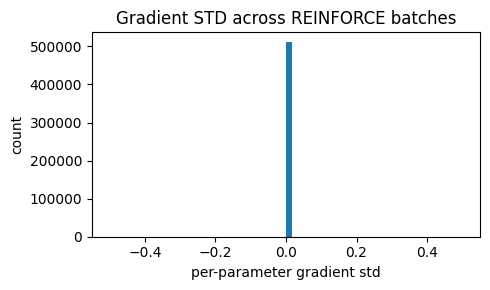

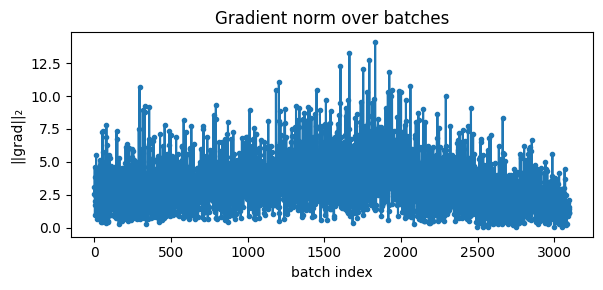


Top-variance param blocks:
('params', 'final_layer', 'kernel') 7.0070e-01
('params', 'layer_1', 'net2', 'kernel') 2.4463e-01
('params', 'layer_0', 'net2', 'kernel') 2.2932e-01
('params', 'layer_0', 'net1', 'kernel') 2.1791e-01
('params', 'layer_1', 'net1', 'kernel') 1.4367e-01


TypeError: list indices must be integers or slices, not str

In [10]:
# plotting the variance in the gradient values over each successive batch:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from flax.traverse_util import flatten_dict
import optax  # only for global_norm plots (pip install optax)

stacked = jax.tree.map(lambda *xs: jnp.stack(xs, axis=0), *[preserved_sum_batch_grads])  # each leaf: (T, ...)

# ---------- 2) Mean / Var / Std across batches ----------
mean_tree = jax.tree.map(lambda x: jnp.mean(x, axis=0), stacked)
var_tree  = jax.tree.map(lambda x: jnp.var(x,  axis=0), stacked)
std_tree  = jax.tree.map(jnp.sqrt, var_tree)

# ---------- 3) Flatten to a vector for global histogram ----------
def tree_to_vec(tree):
    leaves, _ = jax.tree_util.tree_flatten(tree)
    return jnp.concatenate([l.ravel() for l in leaves], axis=0)

std_vec = np.array(tree_to_vec(std_tree))

plt.figure(figsize=(5,3))
plt.hist(std_vec, bins=60)
plt.xlabel("per-parameter gradient std")
plt.ylabel("count")
plt.title("Gradient STD across REINFORCE batches")
plt.tight_layout(); plt.show()

# ---------- 4) Gradient L2 norm per batch (time series) ----------
l2_norms = np.array([optax.global_norm(g) for g in preserved_sum_batch_grads])
plt.figure(figsize=(6,3))
plt.plot(l2_norms, marker='.')
plt.xlabel("batch index")
plt.ylabel("||grad||₂")
plt.title("Gradient norm over batches")
plt.tight_layout(); plt.show()

# ---------- 5) Per-leaf (layer/tensor) variance summary ----------
flat0 = flatten_dict(preserved_sum_batch_grads[0])  # tuple keys -> arrays
per_leaf_std = {}
for k in flat0.keys():
    arrs = [flatten_dict(g)[k].ravel() for g in preserved_sum_batch_grads]
    arrs = np.stack(arrs, axis=0)           # (T, P_leaf)
    per_leaf_std[k] = arrs.std(axis=0).mean()

print("\nTop-variance param blocks:")
for k, v in sorted(per_leaf_std.items(), key=lambda kv: -kv[1])[:5]:
    print(k, f"{v:.4e}")

# ---------- 6) Example heatmap of one kernel’s std ----------
# edit key to match your tree (use print(flat0.keys()) to see options)
leaf_key = ('params','layer_0','net1','kernel')
kernel_std = std_tree['params']['layer_0']['net1']['kernel']
plt.figure(figsize=(4,3))
plt.imshow(np.array(kernel_std), aspect='auto')
plt.colorbar(label='std')
plt.title('Std of layer_0/net1/kernel grads')
plt.tight_layout(); plt.show()

In [ ]:
# print(preserved_sum_batch_grads[347])
# check the working of the model too, implement validation dataset to track losses. 
# print(preserved_sum_batch_grads[3])

{'params': {'final_layer': {'kernel': Array([[-8.5952233e-06],
       [-7.6071410e-06],
       [-1.0791537e-05],
       [ 9.8320379e-06],
       [ 3.8766963e-08]], dtype=float32)}, 'layer_0': {'net1': {'kernel': Array([[-2.5934813e-13,  5.9604659e-08, -2.3841864e-07,  2.3841858e-07,
        -3.4283687e-13,  3.4283690e-13,  2.3270277e-13, -5.9604687e-08],
       [-6.7191272e-06,  5.0262400e-07, -2.3599125e-06,  2.6920304e-06,
        -4.1506842e-06,  4.1259209e-06,  1.2515614e-05, -5.5055142e-07],
       [ 5.8269580e-07,  1.3522545e-07, -5.1059953e-07,  4.8179766e-07,
         3.5995498e-07, -3.5780718e-07, -1.0853777e-06, -1.1859794e-08],
       [ 8.1848348e-06, -3.9545748e-07,  1.8873433e-06, -2.1423193e-06,
         4.9730456e-06, -4.9007062e-06, -1.3674309e-05,  5.3547041e-07],
       [-1.1519917e-06,  8.6174708e-08, -4.0460617e-07,  4.6154753e-07,
        -7.1163328e-07,  7.0738787e-07,  2.1457970e-06, -9.4391858e-08]],      dtype=float32)}, 'net2': {'kernel': Array([[-1.2687345e-0

In [29]:
# print(S_test.shape)
best_sample_list = final_results['best_sample_list']
# print(len(best_sample_list)) # 100

print(best_sample_list[0].keys())

best_err_sample = min(best_sample_list, key=lambda d: d['reconstr_err'])

best_reward_sample = max(best_sample_list, key=lambda d: d['sample_reward'])


dict_keys(['lam_opt', 'phi_bar_mat', 'probability_arr', 'reconstr_err', 'sample_reward', 'selection_arr'])


In [ ]:
# print(best_err_sample['selection_arr'])

# plots to make
# 1. testing error plot using the best sample -lowest reconstr_err
# 2. testing error plot using the best sample -highest sample reward
# 3. batch_reward_values
# 4. 



[1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1]


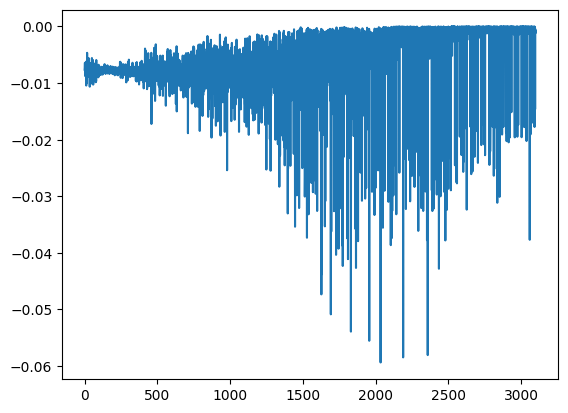

In [32]:
plt.plot(final_results['batch_reward_list'])